# Customer Segmentation using K-Means Clustering

Welcome to this notebook! The aim of this project is to perform customer segmentation using the K-Means clustering algorithm. Customer segmentation is a significant strategy as it allows a business to target specific groups of customers, so as to more effectively allocate marketing resources. For example, one group might contain customers who are high-profit and low-risk, that is, more likely to purchase products, or subscribe for a service. Knowing this information allows a business to devote more time and attention to retaining these customers.

In this notebook, we will be working with a dataset of mall customers from Kaggle. The dataset contains information about the customers such as 'CustomerID', 'Gender', 'Age', 'Annual Income (k$)', and 'Spending Score (1-100)'. Our goal is to segment the customers based on the available data.

We will first perform exploratory data analysis (EDA) to understand our dataset. Then, we will preprocess our data and use the K-Means clustering algorithm to segment the customers. We will use the Elbow Method and the Silhouette Method to determine the optimal number of clusters. We will also visualize our clusters to gain more insights.

Finally, we will implement the K-Means clustering algorithm from scratch to deepen our understanding of how it works.

Let's get started!


In [42]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


df = pd.read_csv("C:/Users/mikhe/OneDrive/Desktop/Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


**No** missing values, so we can start EDA

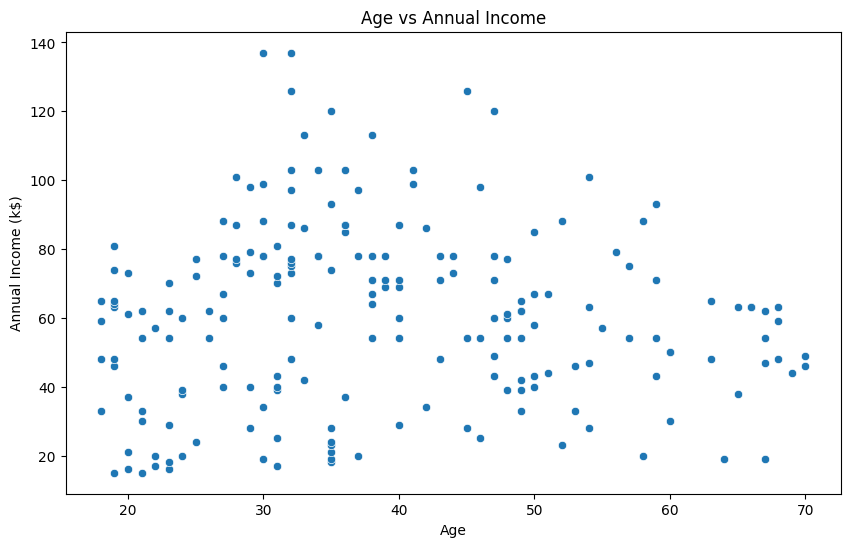

In [44]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Age', y='Annual Income (k$)', data=df)
plt.title('Age vs Annual Income')
plt.show()

As we see, annual income is highest in age group of 30-40, but the data is quite sparse, making it hard to draw solid conclusions

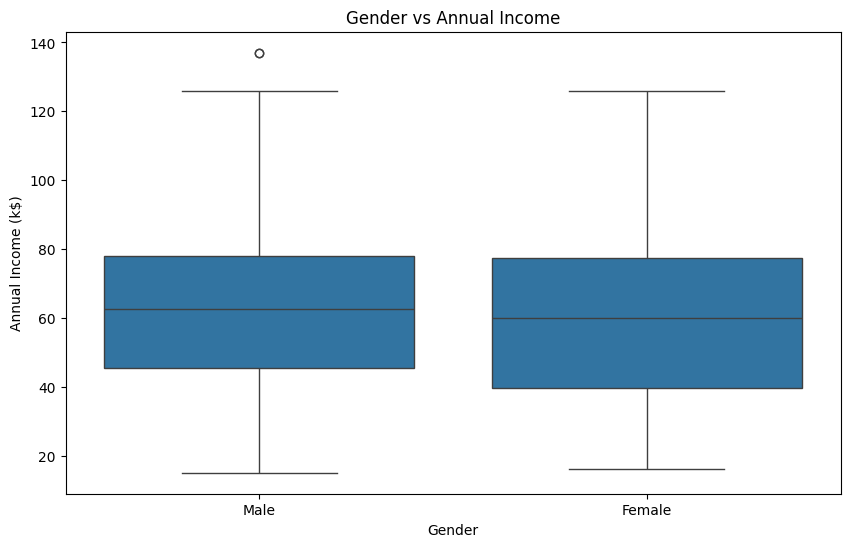

In [45]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Gender', y='Annual Income (k$)', data=df)
plt.title('Gender vs Annual Income')
plt.show()

So, female income is slightly lower.

Now, let us visualize distribution of age groups:

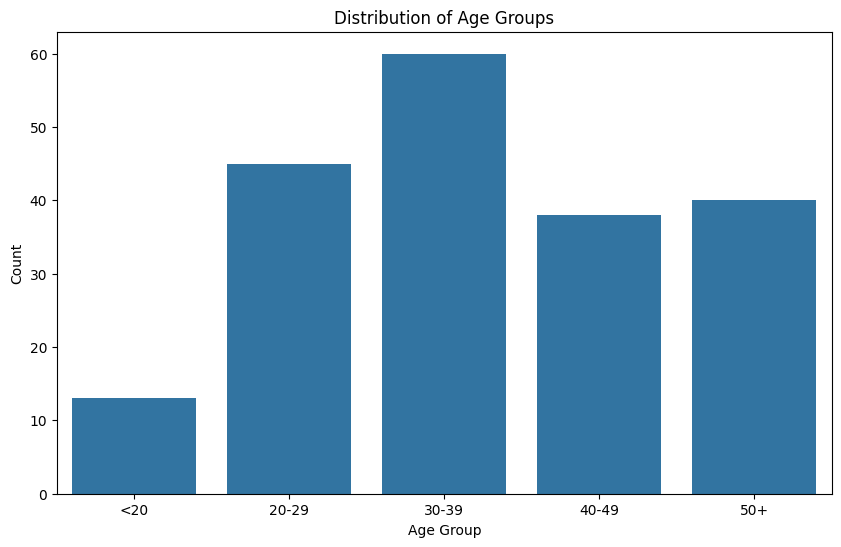

In [46]:
bins = [df['Age'].min(), 20, 30, 40, 50, df['Age'].max()]

group_names = ['<20', '20-29', '30-39', '40-49', '50+']

df['Age Group'] = pd.cut(df['Age'], bins, labels=group_names)


plt.figure(figsize=(10,6))
sns.countplot(x='Age Group', data=df, order=group_names)
plt.title('Distribution of Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

And, visualize spending score by age and gender:

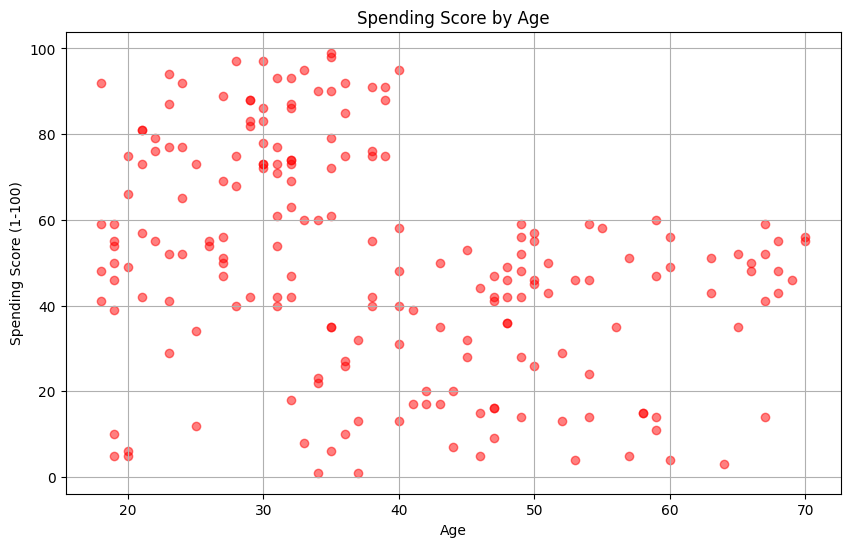

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Age'], df['Spending Score (1-100)'], color='red', alpha=0.5)
plt.title('Spending Score by Age')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.grid(True)
plt.show()

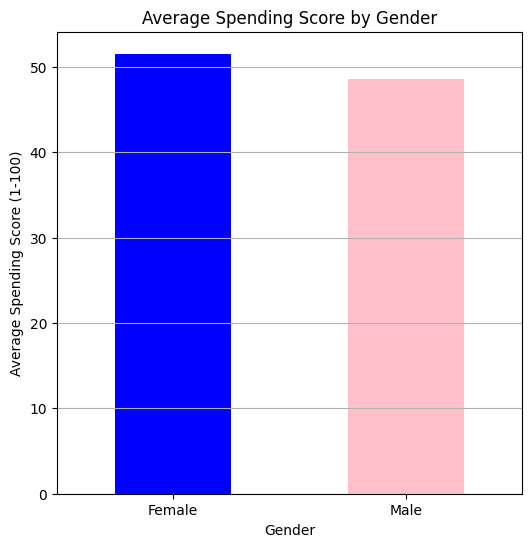

In [48]:
plt.figure(figsize=(6, 6))
gender_groups = df.groupby('Gender')['Spending Score (1-100)'].mean()
gender_groups.plot(kind='bar', color=['blue', 'pink'])
plt.title('Average Spending Score by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Spending Score (1-100)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

Overall, spending score is much higher for age category 0-40 and 40+, but there is no significant difference between genders' average spending scores.

Let us now visualize Spending score by annual income:

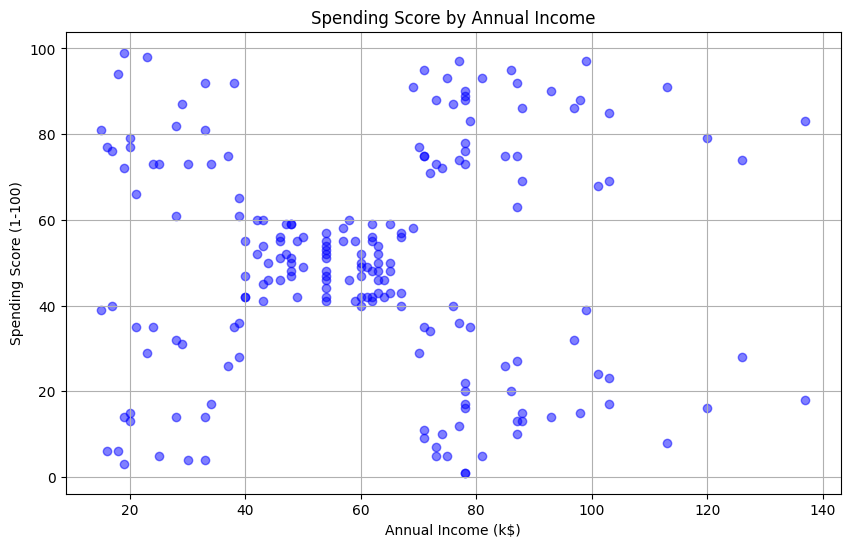

In [49]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], color='blue', alpha=0.5)
plt.title('Spending Score by Annual Income')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.grid(True)
plt.show()

The plot above looks most promising, it can be used to divide customers into groups.
By clustering customers based on these two features, we can potentially identify different segments of customers with similar income levels and spending behaviors.
For example, one cluster might represent customers with high income and high spending scores (potential target customers who can be the focus of marketing efforts), 
while another cluster might represent customers with low income and low spending scores (more price-sensitive customers who might be interested in sales or discounts).
Since our dataset only have 4 dimensions (after dropping customerID column) we do not need dimensionality reduction techniques like PCA. 
Also, even though PCA is extremely useful technique, its drawback is that PCAs are less interpretable than the original features, so let us try and use
"Annual Income" and "Spending Score" as main features without applying PCA to our dataset.

Moreover, our 'Gender' column is of type "object", so, first, we need to transform it to numerical values, before we can use it for k-means clustering algorithm.
Also, we need to drop newly created 'Age Group' column, because it contains categorical data in the form of intervals, the KMeans algorithm can only handle numerical data. Also, we drop 'CustomerID' column because it is essentially an identifier for each customer and doesn’t contain any meaningful information about the customers’ behaviors or characteristics. Including ‘CustomerID’ in the clustering process would mean that the KMeans algorithm tries to find patterns based on these arbitrary identifiers, which can lead to misleading results.

In [50]:
df = df.drop('Age Group',axis=1)
df = df.drop('CustomerID',axis=1)

In [51]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['Gender'] = encoder.fit_transform(df['Gender'])

But, how to choose optimal k (number of groups)? we can use two very common methods: the 'Elbow method' and the 'Silhouette Method'.


**The Elbow Method** uses the concept of WCSS (Within Cluster Sum of Squares) or inertia. It involves running the K-Means algorithm for a range of values of k (number of clusters), and for each 
value of k, calculate the inertia. The plot of inertia against the number of
clusters would appear to have an elbow joint, the point of inflection is considered as the optimal number of clusters.



**Silhouette Method** determines how well each object lies within its cluster. A high average silhouette width indicates a good clustering. The Silhouette Method computes the average silhouette of observations for different values of k. The optimal number of clusters k is the one that maximizes the average silhouette over a range of possible values for k.      
                                              

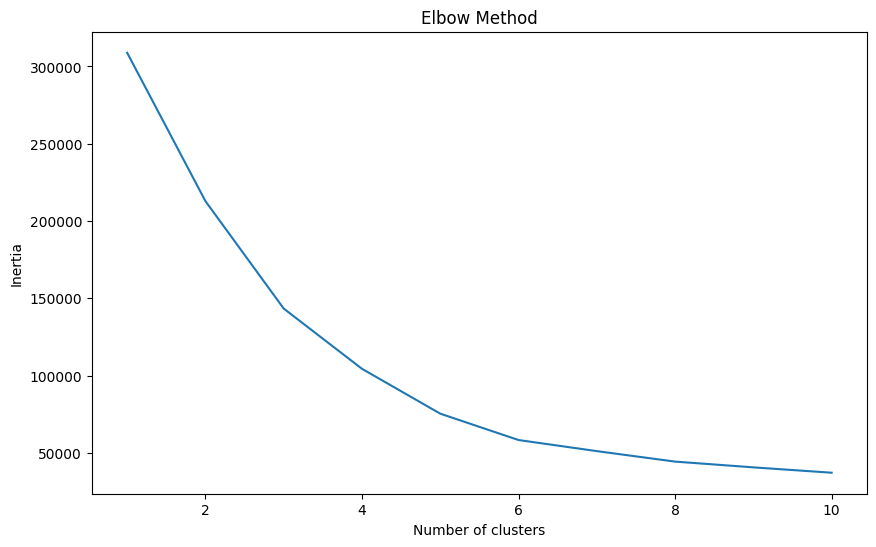

In [52]:
from sklearn.cluster import KMeans


inertia = []


for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

There is no clear 'Elbow' so we need to use 'Silhouette' method

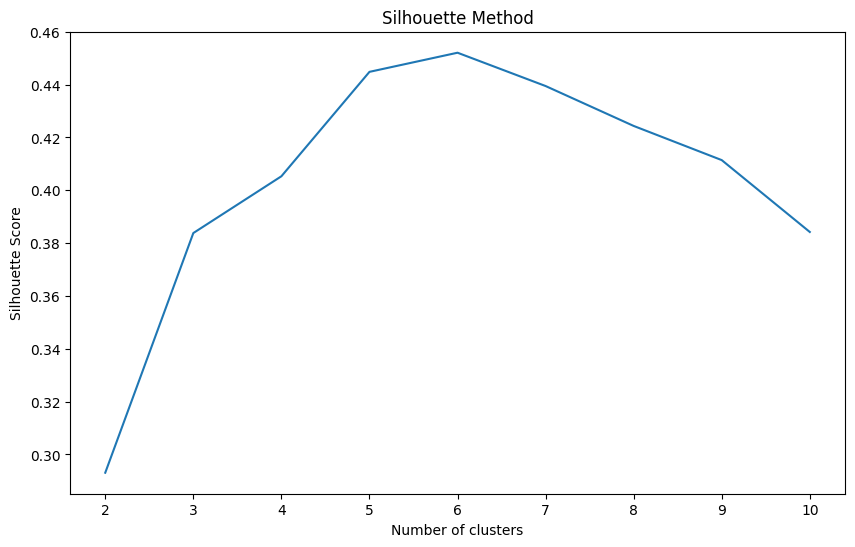

In [53]:
from sklearn.metrics import silhouette_score

sil = []

# We will compute silhouette scores for 2-10 clusters because silhouette score is not defined for a single cluster
for k in range(2, 11):
    kmeans = KMeans(n_clusters = k,n_init = 10).fit(df)
    preds = kmeans.fit_predict(df)
    sil.append(silhouette_score(df, preds, metric = 'euclidean'))

plt.figure(figsize=(10,6))
plt.plot(range(2, 11), sil)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


Silhouette score ranges between -1 and 1 and a coefficient close to +1 means that the instance is well inside its own
cluster and far from other clusters, while score of -1 means that instance was actually assigned to a wrong cluster,
so we are looking for high scores. Based on above results we can say that k=6 is the best choice, and k=2 is the worst choice.
Let us use both values, plot them and see how they compare.

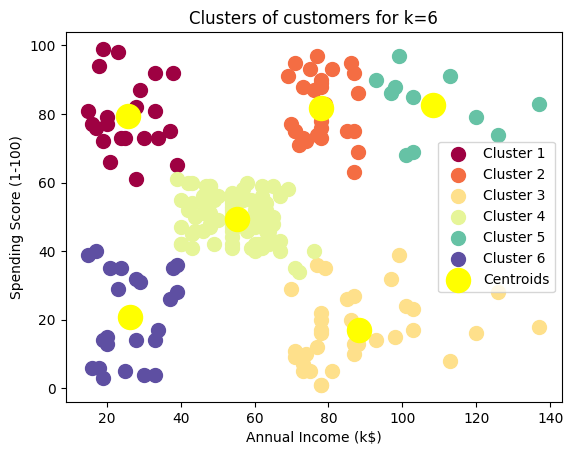

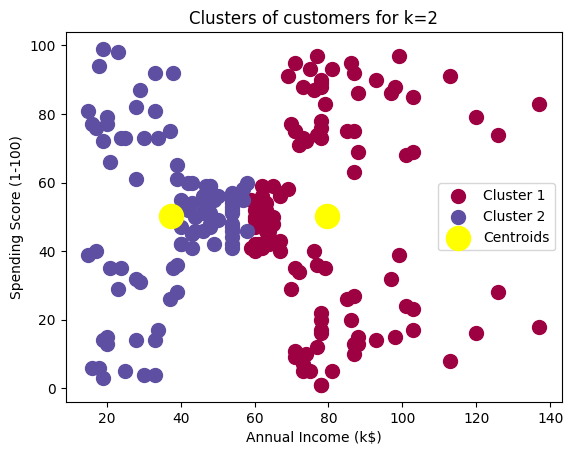

In [54]:
def plot_clusters(X, k):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y = kmeans.fit_predict(X)

  
    colors = plt.cm.Spectral(np.linspace(0, 1, k))


    for i in range(k):
        plt.scatter(X.iloc[pred_y == i, 0], X.iloc[pred_y == i, 1], s = 100, color = colors[i], label = f'Cluster {i+1}')
    

    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
    
    plt.title(f'Clusters of customers for k={k}')
    plt.xlabel('Annual Income (k$)')
    plt.ylabel('Spending Score (1-100)')
    plt.legend()
    plt.show()


X = df[['Annual Income (k$)', 'Spending Score (1-100)']]


plot_clusters(X, 6)


plot_clusters(X, 2)


As we see, k=6 is an optimal choice because it divides our data points into 6 groups which are separated from each other.
Also, k=2 is the bad choice, because it does not capture patterns, does not capture similarities and differences of data points and some of its 'group members' are dramatically different from each other.

### Implementing the algorithm from scratch

Implementing an algorithm from scratch involves understanding the underlying mathematical and logical concepts and.
So we follow the algorithm and translate steps into a programming language.

1. Define the number of clusters (k): This is a crucial decision that influences the outcome. We already did this step, so we use k=2 and k=6.
2. Randomly initialize k centroids: initially placed anywhere in the data space. 
3. Iteratively assign data points to clusters:
   Calculate the distance between each data point and all centroids using a distance metric (e.g., Euclidean distance).
   Assign each data point to the cluster with the closest centroid.
4. Update centroids: Recalculate the centroid (mean) of each cluster based on the newly assigned data points.

5. Repeat steps 3 and 4: Continue iterating until the centroids no longer change significantly or a maximum number of iterations is reached.

In [55]:
import numpy as np

def initialize_centroids(X, k):
    indices = np.random.permutation(X.shape[0])
    centroids = X[indices[:k]]
    return centroids


In [56]:
def assign_to_centroids(X, centroids):
    distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
    cluster_labels = np.argmin(distances, axis=0)
    return cluster_labels


In [57]:
def update_centroids(X, cluster_labels, k):
    new_centroids = np.array([X[cluster_labels==i].mean(axis=0) for i in range(k)])
    return new_centroids


In [58]:
def kmeans(X, k, max_iters=100):
    centroids = initialize_centroids(X, k)
    for _ in range(max_iters):
        cluster_labels = assign_to_centroids(X, centroids)
        new_centroids = update_centroids(X, cluster_labels, k)
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return centroids, cluster_labels


In [59]:
def plot_clusters(X, centroids, cluster_labels):
    plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red')
    plt.show()


In [60]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']].values


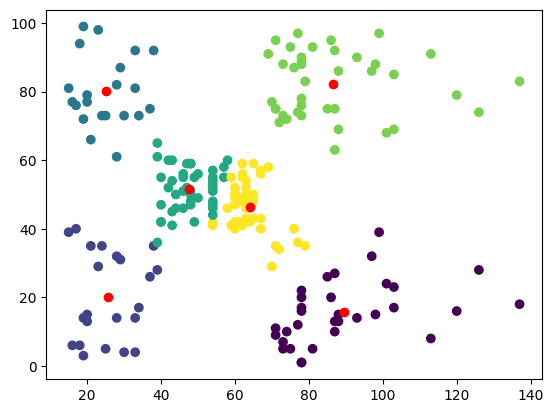

In [61]:
centroids, cluster_labels = kmeans(X, k=6)
plot_clusters(X, centroids, cluster_labels)


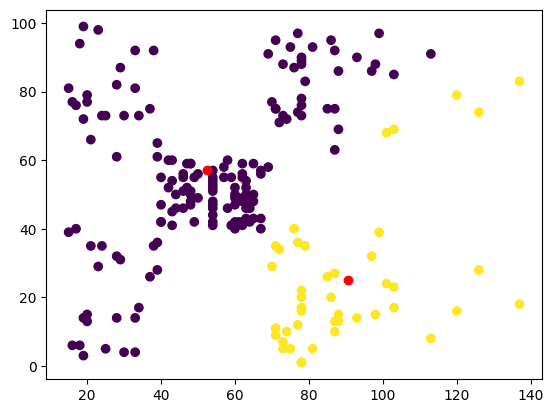

In [62]:
centroids, cluster_labels = kmeans(X, k=2)
plot_clusters(X, centroids, cluster_labels)


Fortunately, results are similar, indicating that algorithm was correctly implemented.

**Note:** We randomly assign centroids, so if we run the code again, clusters would be slighly different, because values depend on the initial placement of the centroids. Let us see!

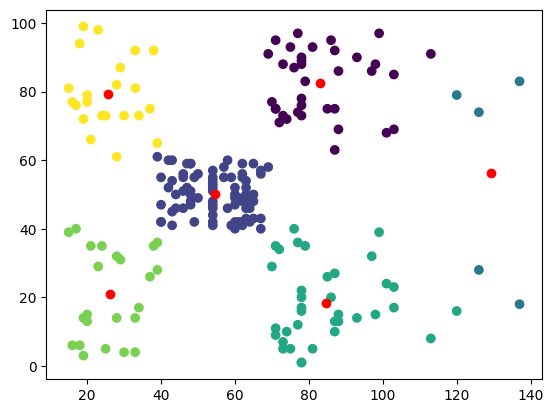

In [63]:
centroids, cluster_labels = kmeans(X, k=6)
plot_clusters(X, centroids, cluster_labels)


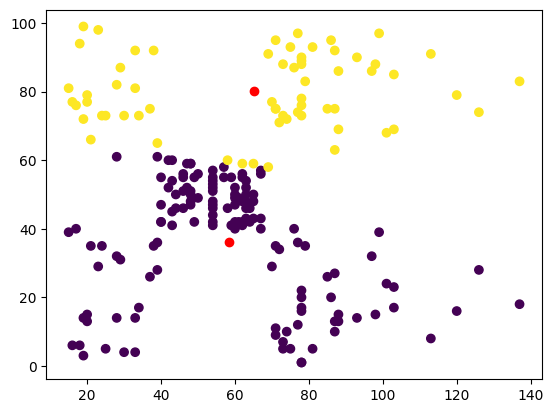

In [64]:
centroids, cluster_labels = kmeans(X, k=2)
plot_clusters(X, centroids, cluster_labels)


Indeed, groups are different, demonstrating that when we different initial centroids lead to different clusters.

There are several ways to mitigate the variability in K-Means results:

**Multiple Initializations:** We can run the K-Means algorithm multiple times with different initial centroid positions. The final clustering result is the one with the lowest inertia.

**K-Means++ Initialization:** This is a smart centroid initialization technique that tends to select initial centroids that are far apart from each other.

## Conclusion

In summary, this study served as an in-depth exploration of the K-Means clustering algorithm. It demonstrated the operational mechanics of the algorithm, provided insights into the selection of an optimal number of clusters (`k`), and presented a comprehensive implementation of the algorithm from scratch. Furthermore, it underscored the impact of initial centroid selection on the resulting clusters, thereby highlighting the inherent variability in the K-Means clustering process. This investigation contributes to a broader understanding of unsupervised learning techniques in the field of machine learning. Thank you!